In [1]:
import bagpipes as pipes
import numpy as np

Bagpipes: Latex distribution not found, plots may look strange.


In [2]:
import pandas as pd
from scipy.integrate import trapz

In [3]:
path_cat = 'cosmos_3dhst.v4.1.cats/Catalog/cosmos_3dhst.v4.1.cat'

In [4]:
#reading in the data
data_cat = np.genfromtxt(path_cat)

#readin gin the column names
columns = np.loadtxt('column_names.txt', dtype=str)

In [5]:
#making a pandas dataframe for easy accessing
df = pd.DataFrame(data = data_cat, columns = columns)

In [6]:
#getting the data with the filters that I have
reduced_df = df[['f_F606W', 'e_F606W', 'f_F814W', 'e_F814W', 'f_F140W', 'e_F140W', 'f_F160W', 'e_F160W', 
                 'f_IRAC1', 'e_IRAC1', 'f_IRAC2', 'e_IRAC2', 'f_IRAC3', 'e_IRAC3', 'f_IRAC4', 'e_IRAC4']]

In [7]:
#converting to array
numpy_arr = reduced_df.to_numpy()

In [63]:
#getting ID 367 data and reshaping it to be a 2 column array
check_ = numpy_arr[185].reshape(-1, 2)

In [64]:
check_

array([[ 9.647828e-01,  4.447482e-02],
       [ 1.289165e+00,  5.607619e-02],
       [-9.900000e+01, -9.900000e+01],
       [ 4.115287e+00,  1.449723e-01],
       [ 6.937791e+00,  3.230646e-01],
       [ 7.325922e+00,  2.832005e-01],
       [ 1.320841e+01,  4.356275e+00],
       [-9.900000e+01, -9.900000e+01]])

In [52]:
#making the bagpipes model

#here I used the delayed_exponential
model_delayedexp = {}
model_delayedexp ['age'] = 1.945 
model_delayedexp ['tau'] = 8.026
model_delayedexp ["metallicity"] = 0.413
model_delayedexp ["massformed"] = 9.960  

dust = {}                               
dust["type"] = "Calzetti"                
dust["Av"] = 0.772                    

model_components = {}
model_components['redshift'] = 1.533
model_components['delayed'] = model_delayedexp
model_components['dust'] = dust

In [53]:
#making the filters path so bagpipes can get filter information
path = 'pipes/filters'
test_filt = [path +'/HST_Filters/ACS_f606w.txt', path +'/HST_Filters/ACS_f814w.txt', path +'/HST_Filters/wfc_f140w.txt', path +'/HST_Filters/wfc_f160w.txt', 
             path +'/IRAC_Filters/IRAC_36_filt.txt', path +'/IRAC_Filters/IRAC_45_filt.txt', path +'/IRAC_Filters/IRAC_58_filt.txt', path +'/IRAC_Filters/IRAC_80_filt.txt']

In [72]:
def effective_lambda(path):
    
    wavelength, transmission = np.loadtxt(path, unpack=True)
    
    num = wavelength * transmission
    
    int_num = trapz(y = num, dx = .1)
    int_denom = trapz(y=transmission, dx = .1)
    
    return round(int_num/int_denom, 4)

In [75]:
eff_wave = []
for i in test_filt:
    eff_wave.append(np.log10(effective_lambda(i)))

In [54]:
galaxy = pipes.model_galaxy(model_components=model_components, filt_list = test_filt, phot_units='mujy')

In [78]:
import matplotlib.pyplot as plt

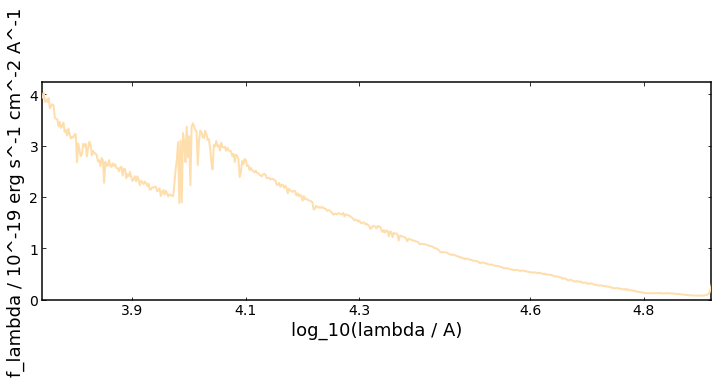

(<Figure size 864x288 with 1 Axes>,
 [<AxesSubplot:xlabel='log_10(lambda / A)', ylabel='f_lambda / 10^-19 erg s^-1 cm^-2 A^-1'>])

In [55]:
galaxy.plot()

In [56]:
#get the photometry of the galaxy in the given filters in mujy
phot_mujy = galaxy.photometry

In [57]:
phot_mujy

array([0.39553639, 0.50523353, 1.48467647, 1.62110748, 2.65294942,
       2.85579502, 2.28066151, 2.26914867])

In [58]:
AB_mag_model = -2.5*np.log10(phot_mujy/1e6) + 8.90

In [66]:
AB_mag_cosmos = -2.5*np.log10(check_[:,0]) + 25

/Users/oscarachavezortiz/opt/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


In [67]:
for i in range(len(AB_mag_model)):
    print(AB_mag_model[i], ' ------------- ', AB_mag_cosmos[i])

24.907033894719568  -------------  25.038926119176047
24.641269582169187  -------------  24.724228734538265
23.470920433259153  -------------  nan
23.37547047560577  -------------  23.46399967927635
22.840677576463342  -------------  22.89694696839614
22.760682418475294  -------------  22.837844274085157
23.004847914856327  -------------  22.19787364668789
23.010342624496623  -------------  nan


In [61]:
#converting it to cosmos flux values
flux_model_cosmo = 10**((AB_mag_model-25)/-2.5)

In [65]:
for i in range(len(test_filt)):
    print(test_filt[i], ' ----------- ', flux_model_cosmo[i], ' --------- ', check_[i, 0])

pipes/filters/HST_Filters/ACS_f606w.txt  -----------  1.089397670104387  ---------  0.9647828
pipes/filters/HST_Filters/ACS_f814w.txt  -----------  1.3915286972233618  ---------  1.289165
pipes/filters/HST_Filters/wfc_f140w.txt  -----------  4.0891385588044  ---------  -99.0
pipes/filters/HST_Filters/wfc_f160w.txt  -----------  4.464900753400409  ---------  4.115287
pipes/filters/IRAC_Filters/IRAC_36_filt.txt  -----------  7.306829431417999  ---------  6.937791
pipes/filters/IRAC_Filters/IRAC_45_filt.txt  -----------  7.865512627275056  ---------  7.325922
pipes/filters/IRAC_Filters/IRAC_58_filt.txt  -----------  6.281463406228249  ---------  13.20841
pipes/filters/IRAC_Filters/IRAC_80_filt.txt  -----------  6.249754388898504  ---------  -99.0


In [43]:
#making the bagpipes model

#here I used the delayed_exponential
model_delayedexp = {}
model_delayedexp ['age'] = 2.928
model_delayedexp ['tau'] = .579
model_delayedexp ["metallicity"] = 1.057
model_delayedexp ["massformed"] = 11.529  

dust = {}                               
dust["type"] = "Calzetti"                
dust["Av"] = .869                    

model_components = {}
model_components['redshift'] = .874
model_components['delayed'] = model_delayedexp
model_components['dust'] = dust

In [45]:
galaxy_median = pipes.model_galaxy(model_components=model_components, filt_list = test_filt, phot_units='mujy')

In [47]:
phot_median = galaxy_median.photometry

In [48]:
AB_mag_model_median = -2.5*np.log10(phot_median/1e6) + 8.90

In [49]:
for i in range(len(AB_mag_model)):
    print(AB_mag_model_median[i], ' ------------- ', AB_mag_cosmos[i])

22.171737397313777  -------------  23.242475684033778
20.761635204760168  -------------  21.836911513479794
19.443154921775204  -------------  nan
19.242978214311215  -------------  20.33373330934866
18.477138986286086  -------------  19.573306689774327
18.810468701355596  -------------  19.904594542713667
18.954876305517253  -------------  20.070443049478797
19.46403767573017  -------------  20.62454255907978


In [50]:
#converting it to cosmos flux values
flux_model_median_cosmo = 10**((AB_mag_model_median-25)/-2.5)

In [51]:
for i in range(len(test_filt)):
    print(test_filt[i], ' ----------- ', flux_model_median_cosmo[i], ' --------- ', check_[i, 0])

pipes/filters/HST_Filters/ACS_f606w.txt  -----------  13.530225696143077  ---------  5.046726
pipes/filters/HST_Filters/ACS_f814w.txt  -----------  49.584497698457  ---------  18.4177
pipes/filters/HST_Filters/wfc_f140w.txt  -----------  167.00829076420342  ---------  -99.0
pipes/filters/HST_Filters/wfc_f160w.txt  -----------  200.820809919998  ---------  73.53713
pipes/filters/IRAC_Filters/IRAC_36_filt.txt  -----------  406.578496448374  ---------  148.1417
pipes/filters/IRAC_Filters/IRAC_45_filt.txt  -----------  299.09731849544727  ---------  109.1848
pipes/filters/IRAC_Filters/IRAC_58_filt.txt  -----------  261.8481306498157  ---------  93.71795
pipes/filters/IRAC_Filters/IRAC_80_filt.txt  -----------  163.82679297132336  ---------  56.25783
